In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import pandas as pd
from glob import glob
import re
import scipy
import os
import sklearn
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelBinarizer
import json
import pickle
import keras
import tensorflow as tf
from keras.models import load_model
import model_functions as mf
import argparse
import itertools
import time

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
#getting current time
start_time = time.time()

In [ ]:
#defining the parser to read arguments from command line
parser = argparse.ArgumentParser("Arg parser")
parser.add_argument("--idx") 
args = vars(parser.parse_args())

job_idx = int(args["idx"])

In [6]:
#gets all possible combinations of changeable parameters
###COMMENT THIS NEXT LINE OUT
job_idx = 3 ##################################
#################################
algorithms = ["benchmark", "NN"]
datasets = ["plaid", "whited", "both"]
input_sources = [("AC", None), ("RMS", [10, 50, 150]), ("RMS", [500, 1000])]
combinations = list(itertools.product(algorithms, datasets, input_sources))

job_params = combinations[job_idx]
algorithm = job_params[0]
dataset = job_params[1]
input_source = job_params[2][0]

In [7]:
#important parameters
test_samples = 5000 #number of test examples
original_freq = 5000
sample_size_range = [50, 100, 500, 1000] #range of training samples per class
save_path = "C:/Users/tslee/IRP Data/DMF_Internship/DATA/" #where the data to be processed is saved
general_report_path = "C:/Users/tslee/IRP Data/DMF_Internship/DATA/" #where the reports are to be saved

#save_path = "/user/work/iw20981/DMF_work/DATA/"
#general_report_path = "/user/work/iw20981/DMF_work/fourth_run/"

#assigning relevant input type
#probably don't need this, just have the input files labelled accordingly
if input_source=="AC":
    freq_range = [150, 500, 1000] #range of freqs in Hz
    base_report_path = general_report_path + "AC_"
elif input_source=="RMS":
    freq_range = job_params[2][1] #range of freqs in Hz
    base_report_path = general_report_path + "RMS_"

#reshaping function
def arr_reshape(data, labels):
    rows = data.shape[0]
    for i in data.shape[2:]:
        rows *= i
    tpose_tuple = list(np.arange(data.ndim))[::-1][:-2]
    tpose_tuple.extend([0, 1])
    tpose_tuple = tuple(tpose_tuple)
    data_reshaped = data.transpose(tpose_tuple).reshape((rows, data.shape[1]))
    labels_duplicated = np.reshape(np.tile(labels, int(rows/data.shape[0])), (-1, 1))
    return data_reshaped, labels_duplicated
#classes
whited_classes = np.array(['AC', 'CFL', 'Fan', 'Fridge', 'HairDryer',
                            'Heater', 'LightBulb', 'Laptop', 'Microwave', 'VacuumCleaner',
                            'WashingMachine'])
plaid_classes = np.array(['Air Conditioner', "Compact Fluorescent Lamp", 'Fan', 'Fridge', 'Hairdryer',
                            'Heater', "Incandescent Light Bulb", 'Laptop', 'Microwave', 'Vacuum',
                            'Washing Machine'])

In [8]:
#loading in relevant dataset
if dataset=="plaid":
    loaded_data = np.load((save_path + "PLAID_5000Hz_"+ input_source +"_AUGMENTED_data.npy"), allow_pickle=True)
    loaded_labels = np.load((save_path + "PLAID_5000Hz_labels.npy"), allow_pickle=True).reshape((-1,))
    
    #assigning report_path
    report_path = base_report_path + "plaid_reports/"
    pass

elif dataset=="whited":
    loaded_data = np.load((save_path + "WHITED_5000Hz_"+ input_source +"_AUGMENTED_data.npy"), allow_pickle=True)
    loaded_labels = np.load((save_path + "WHITED_5000Hz_"+ input_source +"_labels.npy"), 
                            allow_pickle=True).reshape((-1,)).astype("<U30")

    whited_mask = np.isin(loaded_labels, whited_classes).reshape((-1,))
    loaded_labels = loaded_labels[whited_mask]
    loaded_data = loaded_data[whited_mask]
    
    for idx, class_label in enumerate(whited_classes):
        loaded_labels[loaded_labels == class_label] = plaid_classes[idx]
        whited_rows = loaded_data.shape[0]

    #assigning report_path
    report_path = base_report_path + "whited_reports/"
    pass

elif dataset=="both":
    plaid_data = np.load((save_path + "PLAID_5000Hz_"+ input_source +"_AUGMENTED_data.npy"), allow_pickle=True)
    plaid_labels = np.load((save_path + "PLAID_5000Hz_labels.npy"), allow_pickle=True).reshape((-1,))
    whited_data = np.load((save_path + "WHITED_5000Hz_"+ input_source +"_AUGMENTED_data.npy"), allow_pickle=True)
    whited_labels = np.load((save_path + "WHITED_5000Hz_"+ input_source +"_labels.npy"), 
                            allow_pickle=True).reshape((-1,)).astype("<U30")

    #only using whited data whose labels match and changing labels to match plaid
    whited_mask = np.isin(whited_labels, whited_classes).reshape((-1,))
    clean_whited_data = whited_data[whited_mask]
    clean_whited_labels = whited_labels[whited_mask]
    for idx, class_label in enumerate(whited_classes):
        clean_whited_labels[clean_whited_labels == class_label] = plaid_classes[idx]
    del(whited_data)

    ##########
    loaded_data = np.vstack((plaid_data, clean_whited_data))
    loaded_labels = np.vstack((plaid_labels.reshape((-1, 1)), clean_whited_labels.reshape((-1, 1)))).reshape((-1,))

    #assigning report_path
    report_path = base_report_path + "plaid_and_whited_reports/"
    pass

In [15]:
#standard preprocessing steps applied to all data
if input_source=="AC":
    test_samples_num = int(test_samples/100)
elif input_source=="RMS":
    test_samples_num = int(test_samples/50)

#separating test and train set and then reshaping augmented data
test_indices = np.random.choice(loaded_data.shape[0], test_samples_num, replace=False) #get test indices
test_data = loaded_data[test_indices]
test_labels = loaded_labels[test_indices]

#remove test indices from train set
train_data = np.delete(loaded_data, test_indices, axis=0)
train_labels = np.delete(loaded_labels, test_indices)
del(loaded_data)

test_data_reshaped, test_labels_reshaped = arr_reshape(test_data, test_labels)
del(test_data)
train_data_reshaped, train_labels_reshaped = arr_reshape(train_data, train_labels)
del(train_data)

#normalising the data
def norm_func(row):
    return (row-row.mean())/row.std()
norm_test_data = np.apply_along_axis(norm_func, 1, test_data_reshaped)
norm_train_data = np.apply_along_axis(norm_func, 1, train_data_reshaped)


In [16]:
#one hot encoding the labels as required by xgboost and NNs
def label_conversion(labels):
    Y_labels = LabelBinarizer()
    Y_labels.fit(labels)
    label_classes = Y_labels.classes_
    Y_labels = Y_labels.transform(labels)
    return Y_labels, label_classes
#get number of expected labels
binarizer = LabelBinarizer()
binarizer.fit(train_labels)
label_classes = binarizer.classes_

Y_test = test_labels_reshaped
Y_test_onehot = binarizer.transform(test_labels_reshaped)

In [25]:
#carrying out relevant algorithm
if algorithm=="NN":
    #creating an error log file if it doesn't exist already
    if (str(job_idx) + "NN_log.txt") not in glob((report_path + "*")):
        with open((report_path + str(job_idx) + "NN_log.txt"), "w+") as err_file:
            err_file.write("Tests: \n")

    for freq in freq_range:
        for sample_size in sample_size_range:
            """#get indices for the correct number of training samples from each class
            indices_list = []
            for label in label_classes:
                #indices of available instances from each class
                label_indices = np.nonzero(labels_duplicated[X_remaining_indices] == label)[0]
                #get certain number of samples from each class
                label_indices = list(np.random.choice(label_indices, sample_size))
                indices_list.extend(label_indices)
            train_indices = np.asarray(indices_list)"""
            
            #Method to take n total samples which are randomly selected from total sample set
            total_samples = sample_size*len(label_classes)
            train_indices = np.random.choice(norm_train_data.shape[0], total_samples)

            #gets the indices of the current training set, ensuring not to use the same indices as the test set
            downsample_factor = int(original_freq/freq)
            rounded_rows = downsample_factor*freq #in case the new frequency is not exactly divisible
            X_train = norm_train_data[train_indices, :rounded_rows]
            #averaging/downsampling data
            X_train = np.mean(np.reshape(X_train, (X_train.shape[0], -1, downsample_factor)), axis=2)
            
            #onehot encode labels
            Y_train_onehot = binarizer.transform(train_labels_reshaped[train_indices])

            X_test = np.mean(np.reshape(norm_test_data[:, :rounded_rows], (norm_test_data.shape[0], -1, downsample_factor)), axis=2)
            
            
            #print("Using " + str(sample_size) + " training samples," + " at " + str(freq) + " Hz")
            #try to execute NN function, or add to error log file
            try: #Neural Network
                test_time = time.time()
                mf.NN_func(X_train, X_test, Y_train_onehot, Y_test_onehot, label_classes, 
                            report_path, num_epochs=2)
                with open((report_path + str(job_idx) + "NN_log.txt"), "a+") as log_file:
                     log_file.write("NN " + str(sample_size) + " sample size " + "at " + str(freq) + " Hz :" 
                                    + str(time.time()-test_time) + " seconds." + "\n")
                     log_file.write("_" *10+ "\n")
                print("NN Saved")
            except Exception as error:
                with open((report_path + str(job_idx) + "NN_log.txt"), "a+") as err_file:
                    err_file.write("NN " + str(sample_size) + " sample size " + "at " + str(freq) + " Hz \n")
                    err_file.write("AN ERROR OCCURED: " + str(error) + "\n")
                    err_file.write("_" *10+ "\n")
            #break
        #break
    with open((report_path + str(job_idx) + "NN_log.txt"), "a+") as err_file:
                err_file.write("Total Run Time: " + str(time.time() - start_time) + " seconds")

elif algorithm=="benchmark":
    #creating an error log file if it doesn't exist already
    if (str(job_idx) + "benchmark_log.txt") not in glob((report_path + "*")):
        with open((report_path + str(job_idx) + "benchmark_log.txt"), "w+") as err_file:
            err_file.write("Tests: \n")

    for freq in freq_range:
        for sample_size in sample_size_range:
            """#get indices for the correct number of training samples from each class
            indices_list = []
            for label in label_classes:
                #indices of available instances from each class
                label_indices = np.nonzero(labels_duplicated[X_remaining_indices] == label)[0]
                #get certain number of samples from each class
                label_indices = list(np.random.choice(label_indices, sample_size))
                indices_list.extend(label_indices)
            train_indices = np.asarray(indices_list)"""

            total_samples = sample_size*len(label_classes)
            train_indices = np.random.choice(norm_train_data.shape[0], total_samples)

            #gets the indices of the current training set, ensuring not to use the same indices as the test set
            downsample_factor = int(original_freq/freq)
            rounded_rows = downsample_factor*freq #in case the new frequency is not exactly divisible
            X_train = norm_train_data[train_indices, :rounded_rows]
            #averaging/downsampling data
            X_train = np.mean(np.reshape(X_train, (X_train.shape[0], -1, downsample_factor)), axis=2)
            
            #onehot encode labels
            Y_train_onehot = binarizer.transform(train_labels_reshaped[train_indices])
            Y_train = train_labels_reshaped[train_indices].reshape((-1, ))

            X_test = np.mean(np.reshape(norm_test_data[:, :rounded_rows], (norm_test_data.shape[0], -1, downsample_factor)), axis=2)
            
            #print("Using " + str(sample_size) + " training samples," + " at " + str(freq) + " Hz")
            #try to execute each function, or add to error log file
            try: #KNN
                test_time = time.time()
                mf.knn_func(X_train, X_test, Y_train, Y_test, report_path)
                with open((report_path + str(job_idx) + "benchmark_log.txt"), "a+") as log_file:
                     log_file.write("KNN " + str(sample_size) + " sample size " + "at " + str(freq) + " Hz :" 
                                    + str(time.time()-test_time) + " seconds." + "\n")
                     log_file.write("_" *10+ "\n")
                print("KNN Saved")
            except Exception as error:
                with open((report_path + str(job_idx) + "benchmark_log.txt"), "a+") as err_file:
                    err_file.write("KNN " + str(sample_size) + " sample size " + "at " + str(freq) + " Hz \n")
                    err_file.write("AN ERROR OCCURED: " + str(error) + "\n")
                    err_file.write("_" *10+ "\n")

            try: #SVM
                test_time = time.time()
                mf.svm_func(X_train, X_test, Y_train, Y_train_onehot, Y_test, report_path)
                with open((report_path + str(job_idx) + "benchmark_log.txt"), "a+") as log_file:
                     log_file.write("SVM " + str(sample_size) + " sample size " + "at " + str(freq) + " Hz :" 
                                    + str(time.time()-test_time) + " seconds." + "\n")
                     log_file.write("_" *10+ "\n")
                print("SVM Saved")
            except Exception as error:
                with open((report_path + str(job_idx) + "benchmark_log.txt"), "a+") as err_file:
                    err_file.write("SVM " + str(sample_size) + " sample size " + "at " + str(freq) + " Hz \n")
                    err_file.write("AN ERROR OCCURED: " + str(error) + "\n")
                    err_file.write("_" *10 + "\n")

            try: #XGBOOST
                test_time = time.time()
                mf.xgb_func(X_train, X_test, Y_train_onehot, Y_test_onehot, label_classes, report_path)
                with open((report_path + str(job_idx) + "benchmark_log.txt"), "a+") as log_file:
                     log_file.write("XGBoost " + str(sample_size) + " sample size " + "at " + str(freq) + " Hz :" 
                                    + str(time.time()-test_time) + " seconds." + "\n")
                     log_file.write("_" *10+ "\n")
                print("XGBoost Saved")
            except Exception as error:
                with open((report_path + str(job_idx) + "benchmark_log.txt"), "a+") as err_file:
                    err_file.write("XGBoost " + str(sample_size) + " sample size " + "at " + str(freq) + " Hz \n")
                    err_file.write("AN ERROR OCCURED: " + str(error) + "\n")
                    err_file.write("_" *10+ "\n")
            #break
        #break
    with open((report_path + str(job_idx) + "benchmark_log.txt"), "a+") as err_file:
                err_file.write("Total Run Time: " + str(time.time() - start_time) + " seconds")

NN Saved


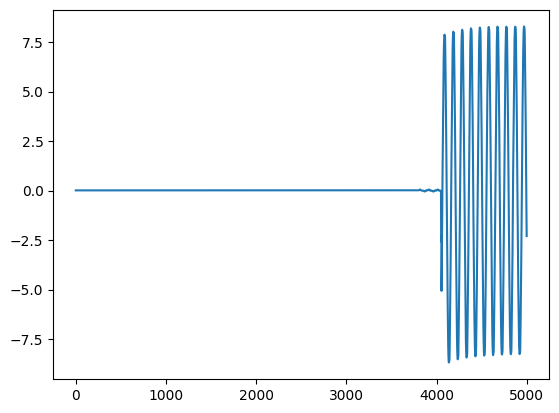

In [41]:
import matplotlib.pyplot as plt
appliance = "Heater"
test_idx = np.where(test_labels_reshaped=="Heater")[0][73]
plt.plot(test_data_reshaped[test_idx, :])